Tutorial 2: Fitting Data
========================

We've learned that a model consists of equations, numerical processes, and assumptions that describe a physical system.
Using **PyAutoFit**, we defined simple 1D models like the Gaussian, composed them into models using `Model` and
`Collection` objects, and generated model data by varying their parameters.

To apply our model to real-world situations, we must fit it to data. Fitting involves assessing how well the model
matches observed data. A good fit indicates that the model's parameter values accurately describe the physical system.
Conversely, a poor fit suggests that adjustments are needed to better reflect reality.

Model-fitting is a cyclical process: define the model, fit it to data, and refine the model based on insights gained.
Iteratively improving the model's complexity enhances its ability to accurately represent the system under study.
This iterative process lies at the core of model-fitting in scientific analysis.

__Astronomy Example__

In Astronomy, this process has been crucial for understanding the distributions of stars within galaxies. By
fitting high-quality images of galaxies with increasingly sophisticated models, astronomers have determined that
stars within galaxies are organized into structures such as disks, bars, and bulges. This approach has also revealed
that stars appear differently in red and blue images due to variations in their age and composition.

__Overview__

In this tutorial, we will explore how to fit the `model_data` generated by a model to actual data. Specifically, we will:

- Load data representing a 1D Gaussian signal, which serves as our target dataset for fitting.

- Compute quantities such as residuals by subtracting the model data from the observed data.

- Quantitatively assess the goodness-of-fit using a critical measure in model-fitting known as the `log_likelihood`.

All these steps will utilize the **PyAutoFit** API for model composition, introduced in the previous tutorial.

__Contents__

This tutorial is split into the following sections:

- **Data**: Load and plot the 1D Gaussian dataset we will fit.
- **Model Data**: Generate model data of the `Gaussian` model using a forward model.
- **Residuals**: Compute and visualize residuals between the model data and observed data.
- **Normalized Residuals**: Compute and visualize normalized residuals, which account for the noise properties of the data.
- **Chi Squared**: Compute and visualize the chi-squared map, a measure of the overall goodness-of-fit.
- **Noise Normalization**: Compute the noise normalization term which describes the noise properties of the data.
- **Likelihood**: Compute the log likelihood, a key measure of the goodness-of-fit of the model to the data.
- **Fitting Models**: Fit the `Gaussian` model to the 1D data and compute the log likelihood, by guessing parameters.
- **Extensibility**: Use the `Collection` object for fitting models with multiple components.
- **Wrap Up**: Summarize the key concepts of this tutorial.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import matplotlib.pyplot as plt
import numpy as np

import autofit as af

/mnt/c/Users/Jammy/Code/PyAuto/stfc_data_summer_school_2024_2
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/stfc_data_summer_school_2024_2`


__Data__

Our dataset consists of noisy 1D data containing a signal, where the underlying signal can be modeled using 
equations such as a 1D Gaussian, a 1D Exponential, or a combination of multiple 1D profiles.

We load this dataset from .json files, where:

- `data` is a 1D NumPy array containing values representing the observed signal.

- `noise_map` is a 1D NumPy array containing values representing the estimated root mean squared (RMS) noise level at 
  each data point.

These datasets are generated using scripts located in `autofit_workspace/howtofit/simulators`. Feel free to explore 
these scripts for more details!

In [2]:
dataset_path = path.join("dataset", "example_1d", "gaussian_x1")

data = af.util.numpy_array_from_json(file_path=path.join(dataset_path, "data.json"))

noise_map = af.util.numpy_array_from_json(
    file_path=path.join(dataset_path, "noise_map.json")
)

Next, we visualize the 1D signal using `matplotlib`.

The signal is observed over uniformly spaced `xvalues`, computed using the `arange` function and `data.shape[0]` method.

We will reuse these `xvalues` shortly when generating model data from the model.

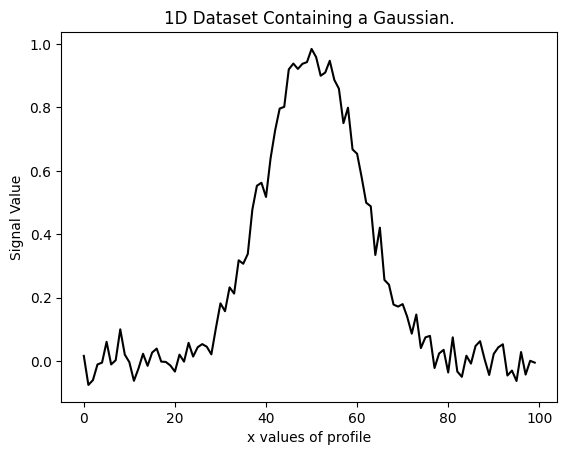

In [3]:
xvalues = np.arange(data.shape[0])
plt.plot(xvalues, data, color="k")
plt.title("1D Dataset Containing a Gaussian.")
plt.xlabel("x values of profile")
plt.ylabel("Signal Value")
plt.show()

The earlier plot depicted only the signal without indicating the estimated noise at each data point.

To visualize both the signal and its `noise_map`, we can use `matplotlib`'s `errorbar` function.

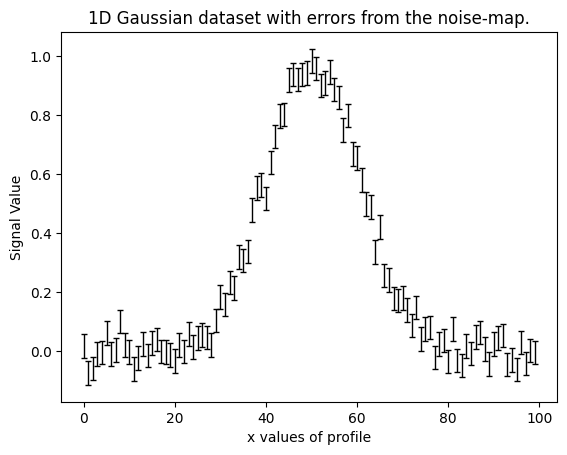

In [4]:
plt.errorbar(
    xvalues,
    data,
    yerr=noise_map,
    linestyle="",
    color="k",
    ecolor="k",
    elinewidth=1,
    capsize=2,
)
plt.title("1D Gaussian dataset with errors from the noise-map.")
plt.xlabel("x values of profile")
plt.ylabel("Signal Value")
plt.show()


__Model Data__

To fit our `Gaussian` model to this data, we start by generating `model_data` from the 1D `Gaussian` model, 
following the same steps as outlined in the previous tutorial.

We begin by again defining the `Gaussian` class, following the **PyAutoFit** format for model components.

In [5]:


class Gaussian:
    def __init__(
        self,
        centre: float = 30.0,  # <- **PyAutoFit** recognises these constructor arguments
        normalization: float = 1.0,  # <- are the Gaussian`s model parameters.
        sigma: float = 5.0,
    ):
        """
        Represents a 1D Gaussian profile.

        This is a model-component of example models in the **HowToFit** lectures and is used to perform model-fitting
        of example datasets.

        Parameters
        ----------
        centre
            The x coordinate of the profile centre.
        normalization
            Overall normalization of the profile.
        sigma
            The sigma value controlling the size of the Gaussian.
        """
        self.centre = centre
        self.normalization = normalization
        self.sigma = sigma

    def model_data_from(self, xvalues: np.ndarray) -> np.ndarray:
        """
        Returns a 1D Gaussian on an input list of Cartesian x coordinates.

        The input xvalues are translated to a coordinate system centred on the Gaussian, via its `centre`.

        The output is referred to as the `model_data` to signify that it is a representation of the data from the
        model.

        Parameters
        ----------
        xvalues
            The x coordinates in the original reference frame of the data.

        Returns
        -------
        np.array
            The Gaussian values at the input x coordinates.
        """
        transformed_xvalues = np.subtract(xvalues, self.centre)
        return np.multiply(
            np.divide(self.normalization, self.sigma * np.sqrt(2.0 * np.pi)),
            np.exp(-0.5 * np.square(np.divide(transformed_xvalues, self.sigma))),
        )


To create `model_data` for the `Gaussian`, we use the model by providing it with `xvalues` corresponding to the 
observed data, as demonstrated in the previous tutorial.

The following code essentially utilizes a forward model to generate the model data based on a specified set of 
parameters.

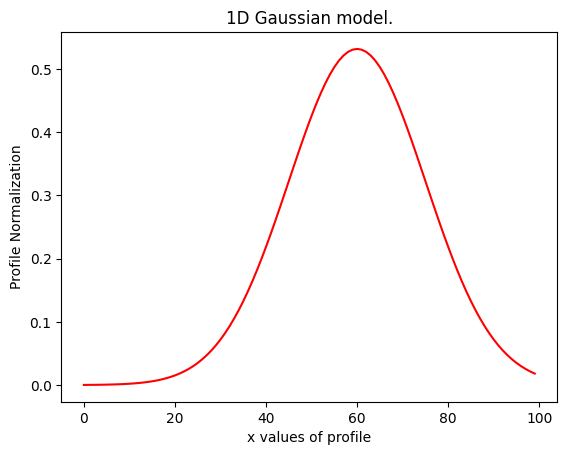

<Figure size 640x480 with 0 Axes>

In [6]:
model = af.Model(Gaussian)

gaussian = model.instance_from_vector(vector=[60.0, 20.0, 15.0])

model_data = gaussian.model_data_from(xvalues=xvalues)

plt.plot(xvalues, model_data, color="r")
plt.title("1D Gaussian model.")
plt.xlabel("x values of profile")
plt.ylabel("Profile Normalization")
plt.show()
plt.clf()

For comparison purposes, it is more informative to plot both the `data` and `model_data` on the same plot.

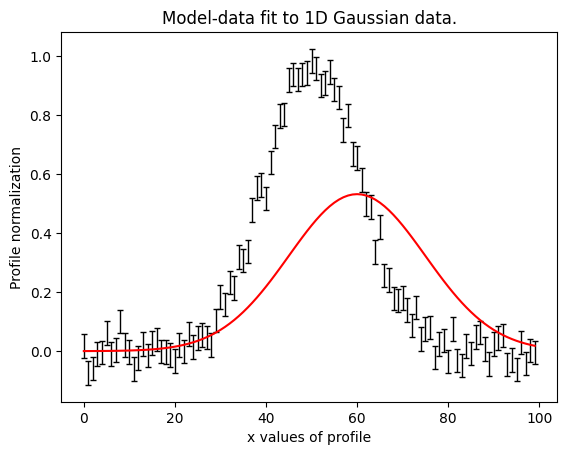

In [7]:
plt.errorbar(
    x=xvalues,
    y=data,
    yerr=noise_map,
    linestyle="",
    color="k",
    ecolor="k",
    elinewidth=1,
    capsize=2,
)
plt.plot(xvalues, model_data, color="r")
plt.title("Model-data fit to 1D Gaussian data.")
plt.xlabel("x values of profile")
plt.ylabel("Profile normalization")
plt.show()
plt.close()

Changing the values of `centre`, `normalization`, and `sigma` alters the appearance of the `Gaussian`.

You can modify the parameters passed into `instance_from_vector()` above. After recomputing the `model_data`, plot 
it again to observe how these changes affect the Gaussian's appearance.

__Residuals__

While it's informative to compare the `data` and `model_data` above, gaining insights from the residuals can be even 
more useful. 

Residuals are calculated as `data - model_data` in 1D:

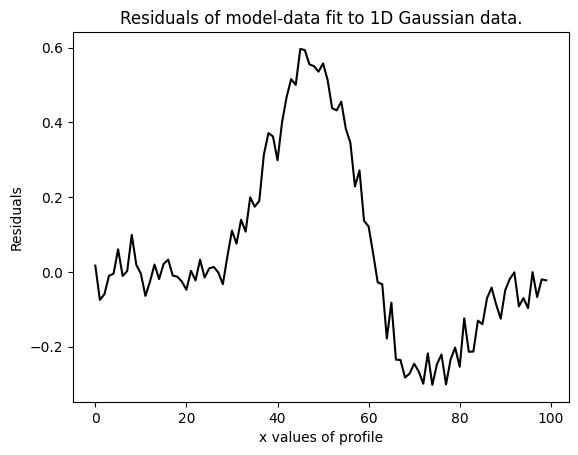

<Figure size 640x480 with 0 Axes>

In [8]:
residual_map = data - model_data
plt.plot(xvalues, residual_map, color="k")
plt.title("Residuals of model-data fit to 1D Gaussian data.")
plt.xlabel("x values of profile")
plt.ylabel("Residuals")
plt.show()
plt.clf()

Are these residuals indicative of a good fit to the data? Without considering the noise in the data, it's difficult 
to ascertain.

We can plot the residuals with error bars based on the noise map. The plot below reveals that the model is a poor fit, 
as many residuals deviate significantly from zero even after accounting for the noise in each data point.

A blue line through zero is included on the plot, to make it clear where residuals are not constent with zero
above the noise level.

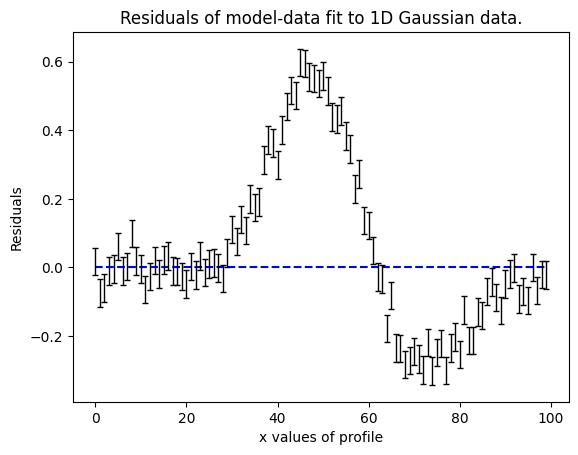

<Figure size 640x480 with 0 Axes>

In [9]:
residual_map = data - model_data
plt.plot(range(data.shape[0]), np.zeros(data.shape[0]), "--", color="b")
plt.errorbar(
    x=xvalues,
    y=residual_map,
    yerr=noise_map,
    color="k",
    ecolor="k",
    elinewidth=1,
    capsize=2,
    linestyle="",
)
plt.title("Residuals of model-data fit to 1D Gaussian data.")
plt.xlabel("x values of profile")
plt.ylabel("Residuals")
plt.show()
plt.clf()

__Normalized Residuals__

Another method to quantify and visualize the quality of the fit is using the normalized residual map, also known as 
standardized residuals.

The normalized residual map is computed as the residual map divided by the noise map:

\[ \text{normalized\_residual} = \frac{\text{residual\_map}}{\text{noise\_map}} = \frac{\text{data} - \text{model\_data}}{\text{noise\_map}} \]

If you're familiar with the concept of standard deviations (sigma) in statistics, the normalized residual map represents 
how many standard deviations the residual is from zero. For instance, a normalized residual of 2.0 (corresponding 
to a 95% confidence interval) means that the probability of the model underestimating the data by that amount is only 5%.

Both the residual map with error bars and the normalized residual map convey the same information. However, 
the normalized residual map is particularly useful for visualization in multidimensional problems, as plotting 
error bars in 2D or higher dimensions is not straightforward.

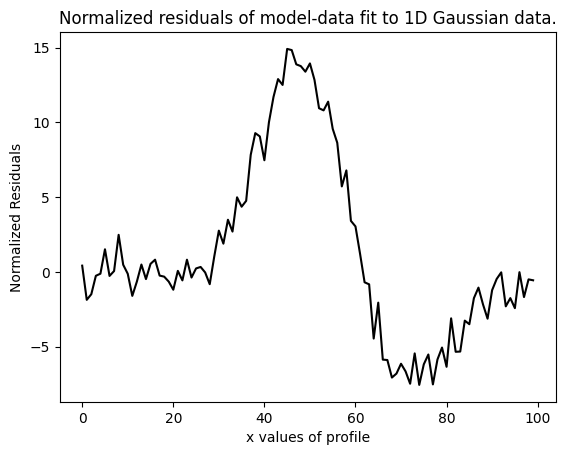

<Figure size 640x480 with 0 Axes>

In [10]:
normalized_residual_map = residual_map / noise_map
plt.plot(xvalues, normalized_residual_map, color="k")
plt.title("Normalized residuals of model-data fit to 1D Gaussian data.")
plt.xlabel("x values of profile")
plt.ylabel("Normalized Residuals")
plt.show()
plt.clf()

__Chi Squared__

Next, we define the `chi_squared_map`, which is obtained by squaring the `normalized_residual_map` and serves as a 
measure of goodness of fit.

The chi-squared map is calculated as:

\[ \chi^2 = \left(\frac{\text{data} - \text{model\_data}}{\text{noise\_map}}\right)^2 \]

The purpose of squaring the normalized residual map is to ensure all values are positive. For instance, both a 
normalized residual of -0.2 and 0.2 would square to 0.04, indicating the same level of fit in terms of `chi_squared`.

As seen from the chi-squared map, it's evident that the model does not provide a good fit to the data.

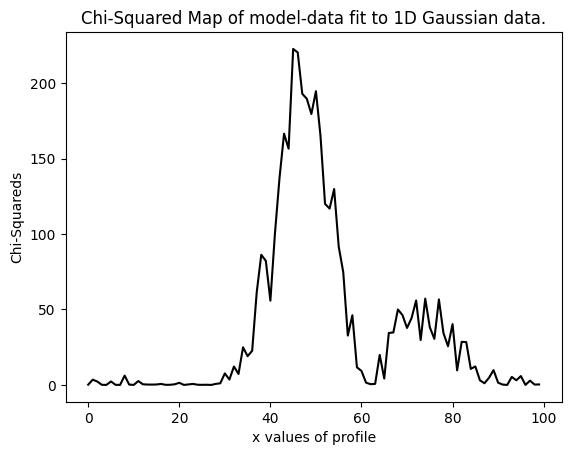

<Figure size 640x480 with 0 Axes>

In [11]:
chi_squared_map = (normalized_residual_map) ** 2
plt.plot(xvalues, chi_squared_map, color="k")
plt.title("Chi-Squared Map of model-data fit to 1D Gaussian data.")
plt.xlabel("x values of profile")
plt.ylabel("Chi-Squareds")
plt.show()
plt.clf()

Now, we consolidate all the information in our `chi_squared_map` into a single measure of goodness-of-fit 
called `chi_squared`. 

It is defined as the sum of all values in the `chi_squared_map` and is computed as:

\[ \chi^2 = \sum \left(\frac{\text{data} - \text{model\_data}}{\text{noise\_map}}\right)^2 \]

This summing process highlights why ensuring all values in the chi-squared map are positive is crucial. If we 
didn't square the values (making them positive), positive and negative residuals would cancel each other out, 
leading to an inaccurate assessment of the model's fit to the data.

In [12]:
chi_squared = np.sum(chi_squared_map)
print("Chi-squared = ", chi_squared)

Chi-squared =  3735.9411779565603


The lower the `chi_squared`, the fewer residuals exist between the model's fit and the data, indicating a better 
overall fit!

__Noise Normalization__

Next, we introduce another quantity that contributes to our final assessment of the goodness-of-fit: 
the `noise_normalization`.

The `noise_normalization` is computed as the logarithm of the sum of squared noise values in our data: 

\[
\text{{noise\_normalization}} = \sum \log(2 \pi \text{{noise\_map}}^2)
\]

This quantity is fixed because the noise-map remains constant throughout the fitting process. Despite this, 
including the `noise_normalization` is considered good practice due to its statistical significance.

Understanding the exact meaning of `noise_normalization` isn't critical for our primary goal of successfully 
fitting a model to a dataset. Essentially, it provides a measure of how well the noise properties of our data align 
with a Gaussian distribution.

In [13]:
noise_normalization = np.sum(np.log(2 * np.pi * noise_map**2.0))

__Likelihood__

From the `chi_squared` and `noise_normalization`, we can define a final goodness-of-fit measure known as 
the `log_likelihood`. 

This measure is calculated by taking the sum of the `chi_squared` and `noise_normalization`, and then multiplying the 
result by -0.5:

\[ \text{log\_likelihood} = -0.5 \times \left( \chi^2 + \text{noise\_normalization} \right) \]

Why multiply by -0.5? The exact rationale behind this factor isn't critical for our current understanding.

In [14]:
log_likelihood = -0.5 * (chi_squared + noise_normalization)
print("Log Likelihood = ", log_likelihood)

Log Likelihood =  -1637.9768598119274


Certainly! Here's a clearer version:

Above, we mentioned that a lower `chi_squared` indicates a better fit of the model to the data. 

When calculating the `log_likelihood`, we multiply the `chi_squared` by -0.5. Therefore, a higher log likelihood 
corresponds to a better model fit. This is what we aim for when fitting models to data, we want to maximize the
log likelihood!

__Recap__

If you're familiar with model-fitting, you've likely encountered terms like 'residuals', 'chi-squared', 
and 'log_likelihood' before. 

These metrics are standard ways to quantify the quality of a model fit. They are applicable not only to 1D data but 
also to more complex data structures like 2D images, 3D data cubes, or any other multidimensional datasets.

If these terms are new to you, it's important to understand their meanings as they form the basis of all 
model-fitting operations in **PyAutoFit** (and in statistical inference more broadly).

Let's recap what we've learned so far:

- We can define models, such as a 1D `Gaussian`, using Python classes that follow a specific format.
  
- Models can be organized using `Collection` and `Model` objects, with parameters mapped to instances of their 
  respective model classes (e.g., `Gaussian`).
  
- Using these model instances, we can generate model data, compare it to observed data, and quantify the 
  goodness-of-fit using the log likelihood.

__Fitting Models__

Now, armed with this knowledge, we are ready to fit our model to our data!

But how do we find the best-fit model, which maximizes the log likelihood?

The simplest approach is to guess parameters. Starting with initial parameter values that yield a good 
fit (i.e., a higher log likelihood), we iteratively adjust these values to refine our model until we achieve an 
optimal fit.

For a 1D `Gaussian`, this iterative process works effectively. Below, we fit three different `Gaussian` models and 
identify the best-fit model—the one that matches the original dataset most closely.

To streamline this process, I've developed functions that compute the `log_likelihood` of a model fit and visualize 
the data alongside the model predictions, complete with error bars.

In [15]:


def log_likelihood_from(
    data: np.ndarray, noise_map: np.ndarray, model_data: np.ndarray
) -> float:
    """
    Compute the log likelihood of a model fit to data given the noise map.

    Parameters
    ----------
    data
        The observed data.
    noise_map
        The root mean square noise (or uncertainty) associated with each data point.
    model_data
        The model's predicted data for the given data x points.

    Returns
    -------
    float
        The log likelihood of the model fit to the data.
    """
    # Calculate residuals and normalized residuals
    residual_map = data - model_data
    normalized_residual_map = residual_map / noise_map

    # Compute chi-squared and noise normalization
    chi_squared_map = normalized_residual_map**2
    chi_squared = np.sum(chi_squared_map)
    noise_normalization = np.sum(np.log(2 * np.pi * noise_map**2.0))

    # Compute log likelihood
    log_likelihood = -0.5 * (chi_squared + noise_normalization)

    return log_likelihood


def plot_model_fit(
    xvalues: np.ndarray,
    data: np.ndarray,
    noise_map: np.ndarray,
    model_data: np.ndarray,
    color: str = "k",
):
    """
    Plot the observed data, model predictions, and error bars.

    Parameters
    ----------
    xvalues
        The x-axis values where the data is observed and model is predicted.
    data
        The observed data points.
    noise_map
        The root mean squared noise (or uncertainty) associated with each data point.
    model_data
        The model's predicted data for the given data x points.
    color
        The color for plotting (default is "k" for black).
    """
    plt.errorbar(
        x=xvalues,
        y=data,
        yerr=noise_map,
        linestyle="",
        color=color,
        ecolor="k",
        elinewidth=1,
        capsize=2,
    )
    plt.plot(xvalues, model_data, color="r")
    plt.title("Fit of model-data to data")
    plt.xlabel("x values of profile")
    plt.ylabel("Profile Value")
    plt.show()
    plt.clf()  # Clear figure to prevent overlapping plots


__Guess 1__

The first guess correctly pinpoints that the Gaussian's peak is at 50.0, but the width and normalization are off.

The `log_likelihood` is computed and printed, however because we don't have a value to compare it to yet, its hard
to assess if it is a large or small value.

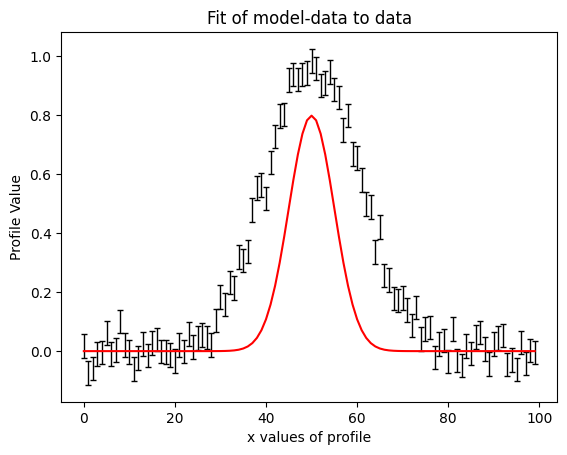

Log Likelihood: -1566.9956208866947


<Figure size 640x480 with 0 Axes>

In [16]:

gaussian = model.instance_from_vector(vector=[50.0, 10.0, 5.0])
model_data = gaussian.model_data_from(xvalues=xvalues)
plot_model_fit(
    xvalues=xvalues,
    data=data,
    noise_map=noise_map,
    model_data=model_data,
    color="r",
)

log_likelihood = log_likelihood_from(
    data=data, noise_map=noise_map, model_data=model_data
)
print(f"Log Likelihood: {log_likelihood}")

__Guess 2__

The second guess refines the width and normalization, but the size of the Gaussian is still off.

The `log_likelihood` is computed and printed, and increases a lot compared to the previous guess, indicating that
the fit is better.

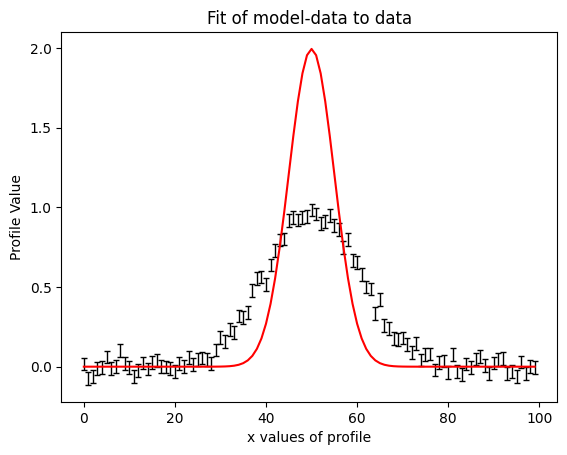

Log Likelihood: -2605.4239333883415


<Figure size 640x480 with 0 Axes>

In [17]:

gaussian = model.instance_from_vector(vector=[50.0, 25.0, 5.0])
model_data = gaussian.model_data_from(xvalues=xvalues)
plot_model_fit(
    xvalues=xvalues,
    data=data,
    noise_map=noise_map,
    model_data=model_data,
    color="r",
)

log_likelihood = log_likelihood_from(
    data=data, noise_map=noise_map, model_data=model_data
)
print(f"Log Likelihood: {log_likelihood}")

__Guess 3__

The third guess provides a good fit to the data, with the Gaussian's peak, width, and normalization all accurately
representing the observed signal.

The `log_likelihood` is computed and printed, and is the highest value yet, indicating that this model provides the
best fit to the data.

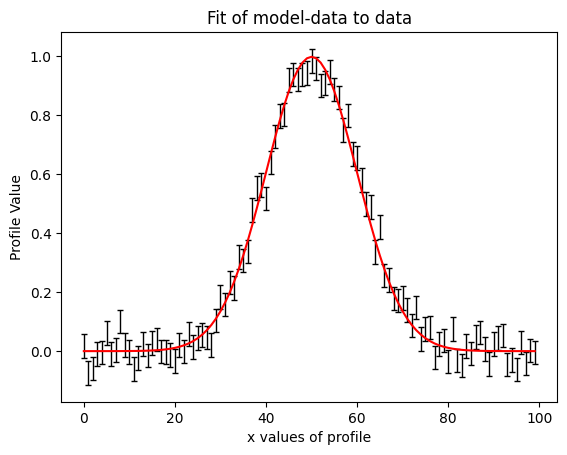

Log Likelihood: 180.97626186867063


<Figure size 640x480 with 0 Axes>

In [18]:

gaussian = model.instance_from_vector(vector=[50.0, 25.0, 10.0])
model_data = gaussian.model_data_from(xvalues=xvalues)
plot_model_fit(
    xvalues=xvalues,
    data=data,
    noise_map=noise_map,
    model_data=model_data,
    color="r",
)

log_likelihood = log_likelihood_from(
    data=data, noise_map=noise_map, model_data=model_data
)
print(f"Log Likelihood: {log_likelihood}")

__Extensibility__

Fitting models composed of multiple components is straightforward with PyAutoFit. Using the `Collection` object, 
we can define complex models consisting of several components. Once defined, we generate `model_data` 
from this collection and fit it to the observed data to compute the log likelihood.

In [19]:
model = af.Collection(gaussian_0=Gaussian, gaussian_1=Gaussian)

instance = model.instance_from_vector(vector=[40.0, 0.2, 0.3, 60.0, 0.5, 1.0])

model_data_0 = instance.gaussian_0.model_data_from(xvalues=xvalues)
model_data_1 = instance.gaussian_1.model_data_from(xvalues=xvalues)

model_data = model_data_0 + model_data_1

We plot the data and model data below, showing that we get a bad fit (a low log likelihood) for this model.

We could attempt to improve the model-fit and find a higher log likelihood solution by varying the parameters of
the two Gaussians. However, with 6 parameters, this would be a challenging and cumbersome task to perform by eye.

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


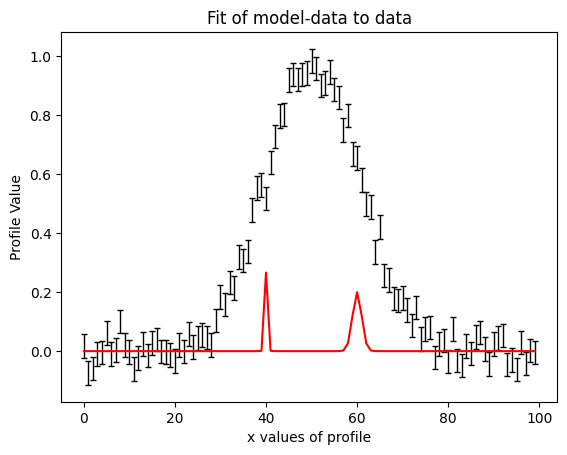

Log Likelihood: -5040.316213367802


<Figure size 640x480 with 0 Axes>

In [20]:
plot_model_fit(
    xvalues=xvalues,
    data=data,
    noise_map=noise_map,
    model_data=model_data,
    color="r",
)

log_likelihood = log_likelihood_from(
    data=data, noise_map=noise_map, model_data=model_data
)
print(f"Log Likelihood: {log_likelihood}")


When our model consisted of only 3 parameters, it was manageable to visually guess their values and achieve a good 
fit to the data. However, as we expanded our model to include six parameters, this approach quickly became 
inefficient. Attempting to manually optimize models with even more parameters would effectively become impossible,
and a more systematic approach is required.

In the next tutorial, we will introduce an automated approach for fitting models to data. This method will enable 
us to systematically determine the optimal values of model parameters that best describe the observed data, without 
relying on manual guesswork.

__Wrap Up__

To conclude, take a moment to reflect on the model you ultimately aim to fit using **PyAutoFit**. What does your 
data look like? Is it one-dimensional, like a spectrum or a time series? Or is it two-dimensional, such as an image 
or a map? Visualize the nature of your data and consider whether you can define a mathematical model that 
accurately generates similar data.

Can you imagine what a residual map would look like if you were to compare your model's predictions against this 
data? A residual map shows the differences between observed data and the model's predictions, often revealing 
patterns or areas where the model fits well or poorly.

Furthermore, can you foresee how you would calculate a log likelihood from this residual map? The log likelihood q
uantifies how well your model fits the data, incorporating both the residual values and the noise characteristics of 
your observations.

If you find it challenging to visualize these aspects right now, that's perfectly fine. The first step is to 
grasp the fundamentals of fitting a model to data using **PyAutoFit**, which will provide you with the tools 
and understanding needed to address these questions effectively in the future.